# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/Users/josuealemansanchez/Desktop/eco-tools')
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')
from data_helper import *
import warnings
warnings.filterwarnings('ignore')

## Get Data

In [2]:
#search for point if needed
point = pc.search_by_point('*gbsf*elec*demand*kbtu*')
point

['GBSF_Electricity_Demand_kBtu']

### Set Data parameters

In [3]:
start = '2016-01-01'
end = '*'
interval = '1h'
calculation = 'summary'

### Ensure only one point is passed

Grabbing WebIDs ...
WebID collection complete!
13:36:14: Sending API request... Chunk 1 of 1
13:36:15: Response recieved for 1 tags! (1.58)


Column                      |Percent NaN | Rows NaN/Total Rows
--------------------------------------------------------------
GBSF_Electricity_Demand_kBtu|  0.07 %    | 23/31497


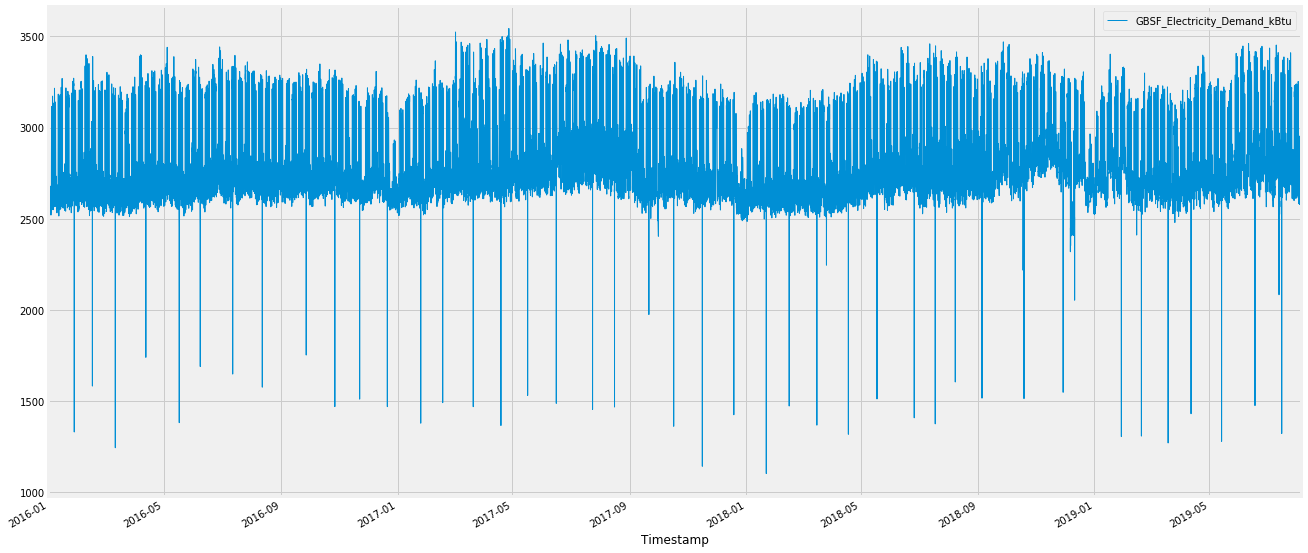

In [4]:
df = pc.get_stream_by_point(point, start = start, end = end, interval = interval, calculation = calculation)
print_report(df)